# Reference Kernel
* https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
* https://www.kaggle.com/kyakovlev/ieee-catboost-baseline-with-groupkfold-cv
* https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
* https://www.kaggle.com/nroman/eda-for-cis-fraud-detection
* https://www.kaggle.com/plasticgrammer/ieee-cis-fraud-detection-eda
* https://www.kaggle.com/kyakovlev/ieee-v-columns-pv

In [1]:
import warnings
warnings.filterwarnings("ignore")

from numba import jit
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import graphviz

from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from scipy.stats import ks_2samp
from scipy.stats.mstats import gmean

from tqdm import tqdm_notebook as tqdm
from IPython.display import display

import os
import gc
import random

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 1000

In [2]:
# Set a few plotting defaults
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 12

In [3]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

In [4]:
SEED = 42
seed_everything(SEED)
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
TARGET = 'isFraud'
NFOLDS = 5

In [5]:
%%time
X = pd.read_pickle('../input/train_reduced.pkl')
X_test = pd.read_pickle('../input/test_reduced.pkl')

sample_submission = pd.read_csv('../input/sample_submission.csv', index_col='TransactionID')

y = X[TARGET]
X = X.drop(TARGET, axis=1)
        
print(f'X.shape : {X.shape}, X_test.shape : {X_test.shape}')

X.shape : (590540, 434), X_test.shape : (506691, 434)
CPU times: user 2.09 s, sys: 2.02 s, total: 4.11 s
Wall time: 4.11 s


In [6]:
def train_val_split_by_time(X, y, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)
    
    print(f'train.shape: {X_train.shape}, val.shape: {X_val.shape}')
    
    return X_train, y_train, X_val, y_val

In [7]:
X_train, y_train, X_val, y_val = train_val_split_by_time(X, y)

train.shape: (472432, 434), val.shape: (118108, 434)


In [8]:
def plot_feature_importance(X, model):
    feature_importance_df = pd.DataFrame()
    feature_importance_df['feature'] = X.columns.tolist()
    feature_importance_df['gain_importance'] = model.feature_importance('gain')
    feature_importance_df['split_importance'] = model.feature_importance('split')

    plt.figure(figsize=(15,10))
    plt.subplot(121)
    plot_1 = sns.barplot(x='gain_importance', y='feature',
                         data=feature_importance_df.sort_values(by='gain_importance', ascending=False)[:50])
    plot_1.set_title('LightGBM Feature Gain Importance')

    plt.subplot(122)
    plot_2 = sns.barplot(x='split_importance', y='feature',
                         data=feature_importance_df.sort_values(by='split_importance', ascending=False)[:50])
    plot_2.set_title('LightGBM Feature Split Importance')
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

def plot_feature_importance(fi_df):
    plt.figure(figsize=(15,10))
    plt.subplot(121)
    plot_1 = sns.barplot(x='gain_importance', y='feature',
                         data=fi_df.sort_values(by='gain_importance', ascending=False)[:50])
    plot_1.set_title('LightGBM Feature Gain Importance')

    plt.subplot(122)
    plot_2 = sns.barplot(x='split_importance', y='feature',
                         data=fi_df.sort_values(by='split_importance', ascending=False)[:50])
    plot_2.set_title('LightGBM Feature Split Importance')
    plt.tight_layout()
    plt.show()    
    
def plot_categorical(field, df_train=None, df_test=None, top_value_cnt=20, target=TARGET):
    train_df = df_train[[field,target,'TransactionAmt']].copy()
    test_df = df_test[[field,target,'TransactionAmt']].copy()
    
    train_df = train_df.fillna('null')
    test_df = test_df.fillna('null')
    
    if train_df[field].nunique() > top_value_cnt:
        top_value_index = train_df[field].value_counts().index[top_value_cnt:]
        train_df.loc[train_df[field].isin(top_value_index), field] = 'Others'
        test_df.loc[test_df[field].isin(top_value_index), field] = 'Others'
        
    
    tmp = pd.crosstab(train_df[field], train_df[target], normalize='index')*100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'Not Fraud', 1:'Fraud'}, inplace=True)
    
    field_order = list(train_df.loc[~train_df[field].isin(['Others'])][field].dropna().unique())
    if train_df[field].isin(['Others']).any():
        field_order.append('Others')

    plt.figure(figsize=(15,15))
    plt.suptitle(f'{field} Distribution', fontsize=22)

    df_train = pd.DataFrame(data={field: train_df[field], 'isTest':0})
    df_test = pd.DataFrame(data={field: test_df[field], 'isTest':1})
    df = pd.concat([df_train, df_test], ignore_index=True)
    plt.subplot(311)
    plot_1 = sns.countplot(x=field, hue='isTest', order=field_order, data=df)
    if len(field_order) > top_value_cnt//2:
        plot_1.set_xticklabels(plot_1.get_xticklabels(), rotation=90, fontsize=10)
    plot_1.legend(['Train','Test'])
    plot_1.set_title(f'{field} train/test Distribution')

    plt.subplot(312)
    plot_2 = sns.countplot(x=field, hue='isFraud', order=field_order, data=train_df)
    if len(field_order) > top_value_cnt//2:
        plot_2.set_xticklabels(plot_2.get_xticklabels(), rotation=90, fontsize=10)
    plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
    plot_2_2 = plot_2.twinx()
    plot_2_2 = sns.pointplot(x=field, y='Fraud', data=tmp, order=field_order, color='black', legend=False)
    plot_2_2.set_ylabel('% of Fraud Transactions', fontsize=16)
    plot_2.set_title(f'{field} Distribution by Target')

    plt.subplot(313)
    plot_3 = sns.boxplot(x=field, y='TransactionAmt', hue=target, order=field_order,
                         data=train_df[train_df['TransactionAmt'] <= 2000])
    if len(field_order) > top_value_cnt//2:
        plot_3.set_xticklabels(plot_3.get_xticklabels(), rotation=90, fontsize=10)
    plot_3.set_title(f'Transaction Amount Distribution by {field} and Target')

    if len(field_order) < top_value_cnt//2:
        plt.subplots_adjust(hspace=0.4)
    else:
        plt.subplots_adjust(hspace=0.8)

    plt.show()
    
def plot_numeric(field, df_train=None, df_test=None, target=TARGET):
    sns.kdeplot(df_train[field], label='train')
    sns.kdeplot(df_test[field], label='test')
    plt.title(f'{field} Distribution')
    plt.show()

    sns.kdeplot(df_train.loc[df_train[target] == 0][field], label='Not Fraud')
    sns.kdeplot(df_train.loc[df_train[target] == 1][field], label='Fraud')
    plt.title(f'{field} Distribution by Target')
    plt.show()
    
    df_train[df_train[target] == 0].set_index('TransactionDT')[field].plot(style='.', label='Train - Not Fraud')
    df_train[df_train[target] == 1].set_index('TransactionDT')[field].plot(style='.', label='Train - Fraud')
    df_test.set_index('TransactionDT')[field].plot(style='.', label='Test')
    plt.title(f'{field} Distribution by TransactionDT')
    plt.legend()
    plt.show()

In [9]:
lgb_params = {
    'objective': 'binary',
    #'metric': 'auc',
    'metric': 'None',
    'learning_rate': 0.01,
    'num_leaves': 2**8,
    'max_bin': 255,
    'max_depth': -1,
    'bagging_freq': 5,
    'bagging_fraction': 0.7,
    'bagging_seed': SEED,
    'feature_fraction': 0.7,
    'feature_fraction_seed': SEED,
    'first_metric_only': True,
    'verbose': 100,
    'n_jobs': -1,
    'seed': SEED,
} 

In [10]:
# https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

In [11]:
def covariate_shift(df_train, df_test, feature, seed=SEED):
    df_f_train = pd.DataFrame(data={feature: df_train[feature], 'isTest': 0})
    df_f_test = pd.DataFrame(data={feature: df_test[feature], 'isTest': 1})

    # Creating a single dataframe
    df = pd.concat([df_f_train, df_f_test], ignore_index=True)
    
    # Encoding if feature is categorical
    if str(df[feature].dtype) in ['object', 'category']:
        df[feature] = LabelEncoder().fit_transform(df[feature].astype(str))
    
    # Splitting it to a training and testing set
    X_train, X_test, y_train, y_test = train_test_split(df[feature], df['isTest'], test_size=0.33,
                                                        random_state=seed, stratify=df['isTest'])

    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': 500,
        'random_state': seed
    }
    
    clf = lgb.LGBMClassifier(**params)
    clf.fit(X_train.values.reshape(-1, 1), y_train)
    roc_auc =  roc_auc_score(y_test, clf.predict_proba(X_test.values.reshape(-1, 1))[:, 1])

    del df, X_train, y_train, X_test, y_test
    gc.collect();
    
    #print('feature:', feature, 'covariate shift:', roc_auc)
    
    return roc_auc

In [12]:
def adversarial_validation(df_train, df_test, threshold=0.7):
    list_auc_value = []

    for i in tqdm(df_train.columns.tolist()):
        auc = covariate_shift(df_test , df_train, i)
        list_auc_value.append(auc)
        if auc > threshold:
            print('feature:', i, 'covariate shift:', auc)

    cov = pd.Series(list_auc_value, index = df_train.columns.tolist()).sort_values() 
    list_discarded = list(cov[cov > threshold].index)
    
    print('features to drop:', list_discarded)
    
    return cov, list_discarded

In [13]:
# https://www.kaggle.com/cdeotte/high-scoring-lgbm-malware-0-702-0-775
# FREQUENCY ENCODE TOGETHER
def freq_encode_full(df1, df2, col, normalize=True):
    df = pd.concat([df1[col],df2[col]])
    vc = df.value_counts(dropna=False, normalize=normalize).to_dict()
    nm = col + '_FE_FULL'
    df1[nm] = df1[col].map(vc)
    df1[nm] = df1[nm].astype('float32')
    df2[nm] = df2[col].map(vc)
    df2[nm] = df2[nm].astype('float32')
    return nm

In [14]:
def timeblock_frequency_encoding(train_df, test_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            print('timeblock frequency encoding:', new_col)
            train_df[new_col] = train_df[col].astype(str)+'_'+train_df[period].astype(str)
            test_df[new_col]  = test_df[col].astype(str)+'_'+test_df[period].astype(str)

            temp_df = pd.concat([train_df[[new_col]], test_df[[new_col]]])
            fq_encode = temp_df[new_col].value_counts(normalize=True).to_dict()

            train_df[new_col] = train_df[new_col].map(fq_encode)
            test_df[new_col]  = test_df[new_col].map(fq_encode)
            
            train_df[new_col] = train_df[new_col]/train_df[period+'_FE_FULL']
            test_df[new_col]  = test_df[new_col]/test_df[period+'_FE_FULL']

    return train_df, test_df

In [15]:
def uid_aggregation(train_df, test_df, main_columns, uids, aggregations):
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = col+'_'+main_column+'_'+agg_type
                print('uid_aggregation:', new_col_name)
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df)
                test_df[new_col_name]  = test_df[col].map(temp_df)
    return train_df, test_df

def values_normalization(dt_df, periods, columns):
    for period in periods:
        for col in columns:
            new_col = col +'_'+ period
            print('values_normalization:', new_col)
            dt_df[col] = dt_df[col].astype(float)  

            temp_min = dt_df.groupby([period])[col].agg(['min']).reset_index()
            temp_min.index = temp_min[period].values
            temp_min = temp_min['min'].to_dict()

            temp_max = dt_df.groupby([period])[col].agg(['max']).reset_index()
            temp_max.index = temp_max[period].values
            temp_max = temp_max['max'].to_dict()

            temp_mean = dt_df.groupby([period])[col].agg(['mean']).reset_index()
            temp_mean.index = temp_mean[period].values
            temp_mean = temp_mean['mean'].to_dict()

            temp_std = dt_df.groupby([period])[col].agg(['std']).reset_index()
            temp_std.index = temp_std[period].values
            temp_std = temp_std['std'].to_dict()

            dt_df['temp_min'] = dt_df[period].map(temp_min)
            dt_df['temp_max'] = dt_df[period].map(temp_max)
            dt_df['temp_mean'] = dt_df[period].map(temp_mean)
            dt_df['temp_std'] = dt_df[period].map(temp_std)

            dt_df[new_col+'_min_max'] = (dt_df[col]-dt_df['temp_min'])/(dt_df['temp_max']-dt_df['temp_min'])
            dt_df[new_col+'_std_score'] = (dt_df[col]-dt_df['temp_mean'])/(dt_df['temp_std'])
            del dt_df['temp_min'],dt_df['temp_max'],dt_df['temp_mean'],dt_df['temp_std']
    return dt_df

In [16]:
def make_val_prediction(X_train, y_train, X_val, y_val, seed=SEED, seed_range=3, lgb_params=lgb_params,
                        category_cols=None):
    print(X_train.shape, X_val.shape)

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    auc_arr = []
    best_iteration_arr = []
    val_preds = np.zeros((X_val.shape[0], seed_range))
    
    feature_importance_df = pd.DataFrame()
    feature_importance_df['feature'] = X_train.columns.tolist()
    feature_importance_df['gain_importance'] = 0
    feature_importance_df['split_importance'] = 0
    
    for i, s in enumerate(range(seed, seed + seed_range)):
        seed_everything(s)
        params = lgb_params.copy()
        params['seed'] = s
        params['bagging_seed'] = s
        params['feature_fraction_seed'] = s

        clf = lgb.train(params, train_data, 10000, valid_sets = [train_data, val_data], categorical_feature=category_cols,
                        early_stopping_rounds=500, feval=eval_auc, verbose_eval=200)

        best_iteration = clf.best_iteration
        best_iteration_arr.append(best_iteration)
        val_pred = clf.predict(X_val, best_iteration)
        val_preds[:, i] = val_pred
        
        auc = fast_auc(y_val, val_pred)
        auc_arr.append(auc)
        print('seed:', s, ', auc:', auc, ', best_iteration:', best_iteration)

        feature_importance_df['gain_importance'] += clf.feature_importance('gain')/seed_range
        feature_importance_df['split_importance'] += clf.feature_importance('split')/seed_range

    auc_arr = np.array(auc_arr)
    best_iteration_arr = np.array(best_iteration_arr)
    best_iteration = int(np.mean(best_iteration_arr))

    avg_pred_auc = fast_auc(y_val, np.mean(val_preds, axis=1))
    print(f'avg pred auc: {avg_pred_auc:.5f}, avg auc: {np.mean(auc_arr):.5f}+/-{np.std(auc_arr):.5f}, avg best iteration: {best_iteration}')

    feature_importance_df = feature_importance_df.sort_values(by='split_importance', ascending=False).reset_index(drop=True)
    plot_feature_importance(feature_importance_df)
    display(feature_importance_df.head(20))
    
    return feature_importance_df, best_iteration, val_preds

In [17]:
def make_test_prediction(X, y, X_test, best_iteration, seed=SEED, category_cols=None):
    print('best iteration:', best_iteration)
    preds = np.zeros((X_test.shape[0], NFOLDS))

    print(X.shape, X_test.shape)
    
    skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=seed)
    
    for i, (trn_idx, _) in enumerate(skf.split(X, y)):
        fold = i + 1
        print('Fold:',fold)
        
        tr_x, tr_y = X.iloc[trn_idx,:], y.iloc[trn_idx]
            
        print(len(tr_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)

        clf = lgb.train(lgb_params, tr_data, best_iteration, categorical_feature=category_cols)
        preds[:, i] = clf.predict(X_test)
    
    return preds

In [18]:
cols_to_drop = [
    'D5_DT_W_std_score',
    'ProductCD_TransactionAmt_DT_W',
    'D4_DT_D_std_score',
    'D15_DT_D_std_score',
    'D3_DT_W_std_score',
    'D11_DT_W_std_score',
    'card3_card5_DT_W_week_day_dist',
    'card5_DT_W_week_day_dist',
    'D10_DT_D_std_score',
    'card3_card5_DT_D',
    'ProductCD_cents_DT_D',
    'D4_DT_W_std_score',
    'D15_DT_W_std_score',
    'uid_DT_D',
    'card3_DT_W_week_day_dist',
    'D10_DT_W_std_score',
    'D8_DT_D_std_score',
    'card3_card5_DT_W',
    'ProductCD_cents_DT_W',
    'uid_DT_W',
    'D8_DT_W_std_score'
]

In [19]:
def fe1(df_train, df_test):
    df_tr = df_train.copy()
    df_te = df_test.copy()
    
    remove_features = [
        'TransactionID','TransactionDT'
    ]
    
    for df in [df_tr, df_te]:
        # Temporary variables for aggregation
        df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
        df['DT_M'] = ((df['DT'].dt.year-2017)*12 + df['DT'].dt.month).astype(np.int8)
        df['DT_W'] = ((df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear).astype(np.int8)
        df['DT_D'] = ((df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear).astype(np.int16)

        df['DT_hour'] = (df['DT'].dt.hour).astype(np.int8)
        df['DT_day_week'] = (df['DT'].dt.dayofweek).astype(np.int8)
        df['DT_day_month'] = (df['DT'].dt.day).astype(np.int8)

        # Possible solo feature
        df['is_december'] = df['DT'].dt.month
        df['is_december'] = (df['is_december']==12).astype(np.int8)
    
    remove_features += ['DT','DT_M','DT_W','DT_D','DT_hour','DT_day_week','DT_day_month']

    for col in ['DT_W','DT_D']:
        freq_encode_full(df_tr, df_te, col)

        # We can't use it as solo feature
        remove_features.append(col+'_FE_FULL')

    for df in [df_tr, df_te]:
        df['ProductCD_card1'] = df['ProductCD'].astype(str) + '_' + df['card1'].astype(str)
        df['card1_addr1'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str)
        #df['card2_dist1'] = df['card2'].astype(str) + '_' + df['dist1'].astype(str)
        df['TransactionAmt_dist2'] = df['TransactionAmt'].astype(str) + '_' + df['dist2'].astype(str)
        #df['card1_dist2'] = df['card1'].astype(str) + '_' + df['dist2'].astype(str)
    remove_features.append('ProductCD_card1')
    remove_features.append('card1_addr1')
    #remove_features.append('card2_dist1')
    remove_features.append('TransactionAmt_dist2')
    #remove_features.append('card1_dist2')
    
    ########################### Card columns "outliers"
    #for col in ['card1','ProductCD_card1','card1_addr1','card2_dist1','TransactionAmt_dist2','card1_dist2']: 
    #for col in ['card1','ProductCD_card1','card1_addr1','card2_dist1']:
    for col in ['card1','ProductCD_card1','card1_addr1','TransactionAmt_dist2']: 
        valid_card = pd.concat([df_tr[[col]], df_te[[col]]])
        valid_card = valid_card[col].value_counts()

        invalid_cards = valid_card[valid_card<=2]
        print('Rare data', col, len(invalid_cards))

        valid_card = valid_card[valid_card>2]
        valid_card = list(valid_card.index)

        print('No intersection in Train', col, len(df_tr[~df_tr[col].isin(df_te[col])]))
        print('Intersection in Train', col, len(df_tr[df_tr[col].isin(df_te[col])]))

        df_tr[col] = np.where(df_tr[col].isin(df_te[col]), df_tr[col], np.nan)
        df_te[col]  = np.where(df_te[col].isin(df_tr[col]), df_te[col], np.nan)

        df_tr[col] = np.where(df_tr[col].isin(valid_card), df_tr[col], np.nan)
        df_te[col]  = np.where(df_te[col].isin(valid_card), df_te[col], np.nan)
        print('#'*20)

    #for col in ['card2','card3','card4','card5','card6','uid']:
    for col in ['card2','card3','card4','card5','card6']: 
        print('No intersection in Train', col, len(df_tr[~df_tr[col].isin(df_te[col])]))
        print('Intersection in Train', col, len(df_tr[df_tr[col].isin(df_te[col])]))

        df_tr[col] = np.where(df_tr[col].isin(df_te[col]), df_tr[col], np.nan)
        df_te[col]  = np.where(df_te[col].isin(df_tr[col]), df_te[col], np.nan)
        print('#'*20)
        
    # Add values remove list
    new_columns = ['uid']
    remove_features += new_columns

    print('#'*10)
    print('Most common uIds:')
    for col in new_columns:
        print('#'*10, col)
        print(df_tr[col].value_counts()[:10])

    # Do Global frequency encoding 
    #i_cols = ['card1','card2','card3','card5','ProductCD_card1','card1_addr1','card2_dist1','TransactionAmt_dist2','card1_dist2'] + new_columns
    #i_cols = ['card1','card2','card3','card5','ProductCD_card1','card1_addr1','card2_dist1'] + new_columns
    i_cols = ['card1','card2','card3','card5','ProductCD_card1','card1_addr1','TransactionAmt_dist2'] + new_columns
    for col in i_cols:
        freq_encode_full(df_tr, df_te, col)
        
    ########################### card3/card5 most common hour 
    # card3 or card5 is a bank country?
    # can we find:
    # - the most popular Transaction Hour
    # - the most popular Week Day
    # and then find distance from it

    # Prepare bank type feature
    for df in [df_tr, df_te]:
        df['card3_card5'] = df['card3'].astype(str) +'_'+ df['card5'].astype(str)
    remove_features.append('card3_card5') 

    encoding_mean = {
        1: ['DT_D','DT_hour','_hour_dist','DT_hour_mean'],
        2: ['DT_W','DT_day_week','_week_day_dist','DT_day_week_mean'],
    }

    encoding_best = {
        1: ['DT_D','DT_hour','_hour_dist_best','DT_hour_best'],
        2: ['DT_W','DT_day_week','_week_day_dist_best','DT_day_week_best'],
    }

    # Some ugly code here (even worse than in other parts)
    for col in ['card3','card5','card3_card5']:
        for df in [df_tr, df_te]:
            for encode in encoding_mean:
                encode = encoding_mean[encode].copy()
                new_col = col + '_' + encode[0] + encode[2]
                df[new_col] = df[col].astype(str) +'_'+ df[encode[0]].astype(str)

                temp_dict = df.groupby([new_col])[encode[1]].agg(['mean']).reset_index().rename(
                                                                        columns={'mean': encode[3]})
                temp_dict.index = temp_dict[new_col].values
                temp_dict = temp_dict[encode[3]].to_dict()
                df[new_col] = df[encode[1]] - df[new_col].map(temp_dict)

            for encode in encoding_best:
                encode = encoding_best[encode].copy()
                new_col = col + '_' + encode[0] + encode[2]
                df[new_col] = df[col].astype(str) +'_'+ df[encode[0]].astype(str)
                temp_dict = df.groupby([col,encode[0],encode[1]])[encode[1]].agg(['count']).reset_index().rename(
                                                                        columns={'count': encode[3]})

                temp_dict.sort_values(by=[col,encode[0],encode[3]], inplace=True)
                temp_dict = temp_dict.drop_duplicates(subset=[col,encode[0]], keep='last')
                temp_dict[new_col] = temp_dict[col].astype(str) +'_'+ temp_dict[encode[0]].astype(str)
                temp_dict.index = temp_dict[new_col].values
                temp_dict = temp_dict[encode[1]].to_dict()
                df[new_col] = df[encode[1]] - df[new_col].map(temp_dict)
        
    ########################### bank_type
    # Tracking nomal activity
    # by doing timeblock frequency encoding
    i_cols = ['uid','card3_card5'] #['uid','uid2','uid3','uid4','uid5','bank_type']
    periods = ['DT_W','DT_D']

    # We have few options to encode it here:
    # - Just count transactions
    # (but some timblocks have more transactions than others)
    # - Devide to total transactions per timeblock (proportions)
    # - Use both
    # - Use only proportions
    df_tr, df_te = timeblock_frequency_encoding(df_tr, df_te, periods, i_cols)
        
    ########################### D Columns
    # From columns description we know that
    # D1-D15: timedelta, such as days between previous transaction, etc.
    # 1. I can't imagine normal negative timedelta values (Let's clip Values)
    # 2. Normalize (Min-Max, Standard score) All D columns, except D1,D2,D9
    # 3. Do some aggregations based on uIDs
    # 4. Freaquency encoding
    # 5. D1,D2 are clipped by max train_df values (let's scale it)
    i_cols = ['D'+str(i) for i in range(1,16)]
    uids = ['uid','card3_card5']
    aggregations = ['mean','std']

    ####### uIDs aggregations
    df_tr, df_te = uid_aggregation(df_tr, df_te, i_cols, uids, aggregations)

    ####### Cleaning Neagtive values and columns transformations
    for df in [df_tr, df_te]:

        for col in i_cols:
            df[col] = df[col].clip(0) 

        # Lets transform D8 and D9 column
        # As we almost sure it has connection with hours
        df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
        df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
        df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
        df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
        df['D8'] = df['D8'].fillna(-1).astype(int)

    ####### Values Normalization
    i_cols.remove('D1')
    i_cols.remove('D2')
    i_cols.remove('D9')
    periods = ['DT_D','DT_W']
    for df in [df_tr, df_te]:
        df = values_normalization(df, periods, i_cols)

    for col in ['D1','D2']:
        for df in [df_tr, df_te]:
            df[col+'_scaled'] = df[col]/df_tr[col].max()

    ####### Global Self frequency encoding
    # self_encoding=True because 
    # we don't need original values anymore
    i_cols = ['D'+str(i) for i in range(1,16)]
    for col in i_cols:
        freq_encode_full(df_tr, df_te, col)
    remove_features += i_cols

    ########################### TransactionAmt
    # Clip Values
    df_tr['TransactionAmt'] = df_tr['TransactionAmt'].clip(0,5000)
    df_te['TransactionAmt']  = df_te['TransactionAmt'].clip(0,5000)

    # Check if the Transaction Amount is common or not (we can use freq encoding here)
    # In our dialog with a model we are telling to trust or not to these values   
    df_tr['TransactionAmt_check'] = np.where(df_tr['TransactionAmt'].isin(df_te['TransactionAmt']), 1, 0)
    df_te['TransactionAmt_check']  = np.where(df_te['TransactionAmt'].isin(df_tr['TransactionAmt']), 1, 0)

    # For our model current TransactionAmt is a noise
    # https://www.kaggle.com/kyakovlev/ieee-check-noise
    # (even if features importances are telling contrariwise)
    # There are many unique values and model doesn't generalize well
    # Lets do some aggregations
    i_cols = ['TransactionAmt']
    uids = ['card1','card2','card3','card5','uid','card3_card5']
    aggregations = ['mean','std']

    # uIDs aggregations
    df_tr, df_te = uid_aggregation(df_tr, df_te, i_cols, uids, aggregations)

    # TransactionAmt Normalization
    periods = ['DT_D','DT_W']
    for df in [df_tr, df_te]:
        df = values_normalization(df, periods, i_cols)

    #i_cols = ['id_01','id_02','id_05','id_06','id_07','id_08','id_09','id_14']
    i_cols = ['id_01','id_02','id_05','id_06','id_09','id_14']
    uids = ['card1','card2','card3','card5','uid','card3_card5']
    aggregations = ['mean','std']

    # uIDs aggregations
    df_tr, df_te = uid_aggregation(df_tr, df_te, i_cols, uids, aggregations)

    i_cols = [
        #'V202','V203','V204','V317','V318','V257','V258',
        'V258',
        'V306','V307','V308','V294'
    ]
    uids = ['uid','card3_card5']
    aggregations = ['mean','std']

    # uIDs aggregations
    df_tr, df_te = uid_aggregation(df_tr, df_te, i_cols, uids, aggregations)

    # ProductCD, TransactionAmt
    df_tr['ProductCD_TransactionAmt'] = df_tr['ProductCD'].astype(str)+'_'+df_tr['TransactionAmt'].astype(str)
    df_te['ProductCD_TransactionAmt'] = df_te['ProductCD'].astype(str)+'_'+df_te['TransactionAmt'].astype(str)

    i_cols = ['ProductCD_TransactionAmt']
    periods = ['DT_D','DT_W']
    df_tr, df_te = timeblock_frequency_encoding(df_tr, df_te, periods, i_cols)
    for col in i_cols:
        freq_encode_full(df_tr, df_te, col)
    remove_features += i_cols
    
    df_tr['cents'] = np.round( df_tr['TransactionAmt'] - np.floor(df_tr['TransactionAmt']),3 )
    df_te['cents'] = np.round( df_te['TransactionAmt'] - np.floor(df_te['TransactionAmt']),3 )

    i_cols = ['cents']
    remove_features += i_cols
    
    # ProductCD, cents
    df_tr['ProductCD_cents'] = df_tr['ProductCD'].astype(str)+'_'+df_tr['cents'].astype(str)
    df_te['ProductCD_cents'] = df_te['ProductCD'].astype(str)+'_'+df_te['cents'].astype(str)

    i_cols = ['ProductCD_cents']
    periods = ['DT_D','DT_W']
    df_tr, df_te = timeblock_frequency_encoding(df_tr, df_te, periods, i_cols)
    for col in i_cols:
        freq_encode_full(df_tr, df_te, col)
    remove_features += i_cols
    
    # Small "hack" to transform distribution 
    # (doesn't affect auc much, but I like it more)
    # please see how distribution transformation can boost your score 
    # (not our case but related)
    # https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html
    df_tr['TransactionAmt'] = np.log1p(df_tr['TransactionAmt'])
    df_te['TransactionAmt'] = np.log1p(df_te['TransactionAmt'])
    
    ########################### C Columns
    i_cols = ['C'+str(i) for i in range(1,15)]
    
    for df in [df_tr, df_te]:
        df['c_cols_0_bin'] = ''
        for c in i_cols:
            df['c_cols_0_bin'] += (df[c] == 0).astype(int).astype(str)    
    freq_encode_full(df_tr, df_te, 'c_cols_0_bin')

    ####### Global Self frequency encoding
    # self_encoding=False because 
    # I want to keep original values
    for col in i_cols:
        freq_encode_full(df_tr, df_te, col)

    uids = ['card1','card2','card3','card5','uid','card3_card5']
    aggregations = ['mean','std']

    ####### uIDs aggregations
    df_tr, df_te = uid_aggregation(df_tr, df_te, i_cols, uids, aggregations)
    
    ####### Clip max values
    for df in [df_tr, df_te]:
        for col in i_cols:
            max_value = df_tr[df_tr['DT_M']==df_tr['DT_M'].max()][col].max()
            df[col] = df[col].clip(None,max_value) 

            
    ########################### dist1, dist2 Columns
    i_cols = ['dist1']
    uids = ['card1','card2','card3','card5','uid','card3_card5']
    aggregations = ['mean','std']

    ####### uIDs aggregations
    df_tr, df_te = uid_aggregation(df_tr, df_te, i_cols, uids, aggregations)

    
    
    ####### V feature - nan group agg
    nans_groups = {}
    nans_df = pd.concat([df_tr, df_te]).isna()

    i_cols = ['V'+str(i) for i in range(1,340)]
    for col in i_cols:
        cur_group = nans_df[col].sum()
        if cur_group>0:
            try:
                nans_groups[cur_group].append(col)
            except:
                nans_groups[cur_group]=[col]

    for i, (n_group, n_cols) in enumerate(nans_groups.items()):
        print('processing nan group agg for:', n_cols)
        for df in [df_tr, df_te]:
            df[f'nan_group_{i}_sum'] = df[n_cols].sum(axis=1)
            df[f'nan_group_{i}_mean'] = df[n_cols].mean(axis=1)
            df[f'nan_group_{i}_std'] = df[n_cols].std(axis=1)

    del nans_groups, nans_df
    remove_features += i_cols
    
    
    ########################### Device info and identity
    for df in [df_tr, df_te]:
        ########################### Device info
        df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
        df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
        df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))

        ########################### Device info 2
        df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
        df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
        df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))

        ########################### Browser
        df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
        df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

    i_cols = [
        'DeviceInfo','DeviceInfo_device','DeviceInfo_version',
        'id_30','id_30_device','id_30_version',
        'id_31','id_31_device',
        'id_33',
    ]

    ####### Global Self frequency encoding
    # self_encoding=True because 
    # we don't need original values anymore
    for col in i_cols:
        freq_encode_full(df_tr, df_te, col)
    remove_features += i_cols
    
    i_cols = [
        'id_01',
        'id_03',
        'id_04',
        'id_05',
        'id_06',
        'id_07',
        'id_08',
        'id_09',
        'id_10',
        'id_11',
        'id_13',
        'id_14',
        'id_17',
        'id_18',
        'id_19',
        'id_20',
        'id_21',
        'id_22',
        'id_24',
        'id_25',
        'id_26',
    ]
    for col in i_cols:
        freq_encode_full(df_tr, df_te, col)
    
        
    # Label Encoding
    for f in df_tr.columns:
        if df_tr[f].dtype=='object' or df_te[f].dtype=='object':
            df_tr[f] = df_tr[f].fillna('unseen_before_label')
            df_te[f] = df_te[f].fillna('unseen_before_label')
            lbl = LabelEncoder()
            lbl.fit(list(df_tr[f].values) + list(df_te[f].values))
            df_tr[f] = lbl.transform(list(df_tr[f].values))
            df_te[f] = lbl.transform(list(df_te[f].values))
            df_tr[f] = df_tr[f].astype('category')
            df_te[f] = df_te[f].astype('category')

    remove_features += cols_to_drop
    print('remove_features:', remove_features)
    print(f'train.shape : {df_tr.shape}, test.shape : {df_te.shape}')
    
    ########################### Final features list
    feature_columns = [col for col in list(df_tr) if col not in remove_features]
    categorical_features = [col for col in feature_columns if df_tr[col].dtype.name == 'category']
    categorical_features = [col for col in categorical_features if col not in remove_features]
    
    return df_tr[feature_columns], df_te[feature_columns], categorical_features

In [20]:
#X_fe, X_test_fe, category_cols = fe1(X, X_test)

In [21]:
#cov, cols_to_drop = adversarial_validation(X_fe, X_test_fe)
#print(cols_to_drop)
#cov

Rare data card1 5134
No intersection in Train card1 20399
Intersection in Train card1 452033
####################
Rare data ProductCD_card1 10509
No intersection in Train ProductCD_card1 33115
Intersection in Train ProductCD_card1 439317
####################
Rare data card1_addr1 21640
No intersection in Train card1_addr1 57867
Intersection in Train card1_addr1 414565
####################
Rare data TransactionAmt_dist2 29957
No intersection in Train TransactionAmt_dist2 70254
Intersection in Train TransactionAmt_dist2 402178
####################
No intersection in Train card2 6102
Intersection in Train card2 466330
####################
No intersection in Train card3 146
Intersection in Train card3 472286
####################
No intersection in Train card4 0
Intersection in Train card4 472432
####################
No intersection in Train card5 7339
Intersection in Train card5 465093
####################
No intersection in Train card6 45
Intersection in Train card6 472387
###############

uid_aggregation: card5_id_14_std
uid_aggregation: uid_id_14_mean
uid_aggregation: uid_id_14_std
uid_aggregation: card3_card5_id_14_mean
uid_aggregation: card3_card5_id_14_std
uid_aggregation: uid_V258_mean
uid_aggregation: uid_V258_std
uid_aggregation: card3_card5_V258_mean
uid_aggregation: card3_card5_V258_std
uid_aggregation: uid_V306_mean
uid_aggregation: uid_V306_std
uid_aggregation: card3_card5_V306_mean
uid_aggregation: card3_card5_V306_std
uid_aggregation: uid_V307_mean
uid_aggregation: uid_V307_std
uid_aggregation: card3_card5_V307_mean
uid_aggregation: card3_card5_V307_std
uid_aggregation: uid_V308_mean
uid_aggregation: uid_V308_std
uid_aggregation: card3_card5_V308_mean
uid_aggregation: card3_card5_V308_std
uid_aggregation: uid_V294_mean
uid_aggregation: uid_V294_std
uid_aggregation: card3_card5_V294_mean
uid_aggregation: card3_card5_V294_std
timeblock frequency encoding: ProductCD_TransactionAmt_DT_D
timeblock frequency encoding: ProductCD_TransactionAmt_DT_W
timeblock frequ

processing nan group agg for: ['V167', 'V168', 'V172', 'V173', 'V176', 'V177', 'V178', 'V179', 'V181', 'V182', 'V183', 'V186', 'V187', 'V190', 'V191', 'V192', 'V193', 'V196', 'V199', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216']
processing nan group agg for: ['V169', 'V170', 'V171', 'V174', 'V175', 'V180', 'V184', 'V185', 'V188', 'V189', 'V194', 'V195', 'V197', 'V198', 'V200', 'V201', 'V208', 'V209', 'V210']
processing nan group agg for: ['V217', 'V218', 'V219', 'V223', 'V224', 'V225', 'V226', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V235', 'V236', 'V237', 'V240', 'V241', 'V242', 'V243', 'V244', 'V246', 'V247', 'V248', 'V249', 'V252', 'V253', 'V254', 'V257', 'V258', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278']
processing nan group agg for: ['V220', 'V221', 'V222', 'V227', 'V234', 'V238', 'V239', 'V245', 'V250', 'V251', 'V255', 'V256', 'V259', 'V27

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'c_cols_0_bin', 'card4', 'card6', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'c_cols_0_bin', 'card4', 'card6', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
  'New categorical_feature is {}'.format(sorted(list(ca

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.983652	valid_1's auc: 0.931067
[400]	training's auc: 0.997084	valid_1's auc: 0.942
[600]	training's auc: 0.999506	valid_1's auc: 0.945636
[800]	training's auc: 0.999888	valid_1's auc: 0.947219
[1000]	training's auc: 0.999971	valid_1's auc: 0.948006
[1200]	training's auc: 0.999988	valid_1's auc: 0.948384
[1400]	training's auc: 0.99999	valid_1's auc: 0.948394
[1600]	training's auc: 0.99999	valid_1's auc: 0.948451
[1800]	training's auc: 0.999991	valid_1's auc: 0.948132
Early stopping, best iteration is:
[1472]	training's auc: 0.999991	valid_1's auc: 0.948444
seed: 42 , auc: 0.9484444954178481 , best_iteration: 1472
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.983802	valid_1's auc: 0.930909
[400]	training's auc: 0.9973	valid_1's auc: 0.941656
[600]	training's auc: 0.999509	valid_1's auc: 0.945726
[800]	training's auc: 0.999904	valid_1's auc: 0.947371
[1000]	train

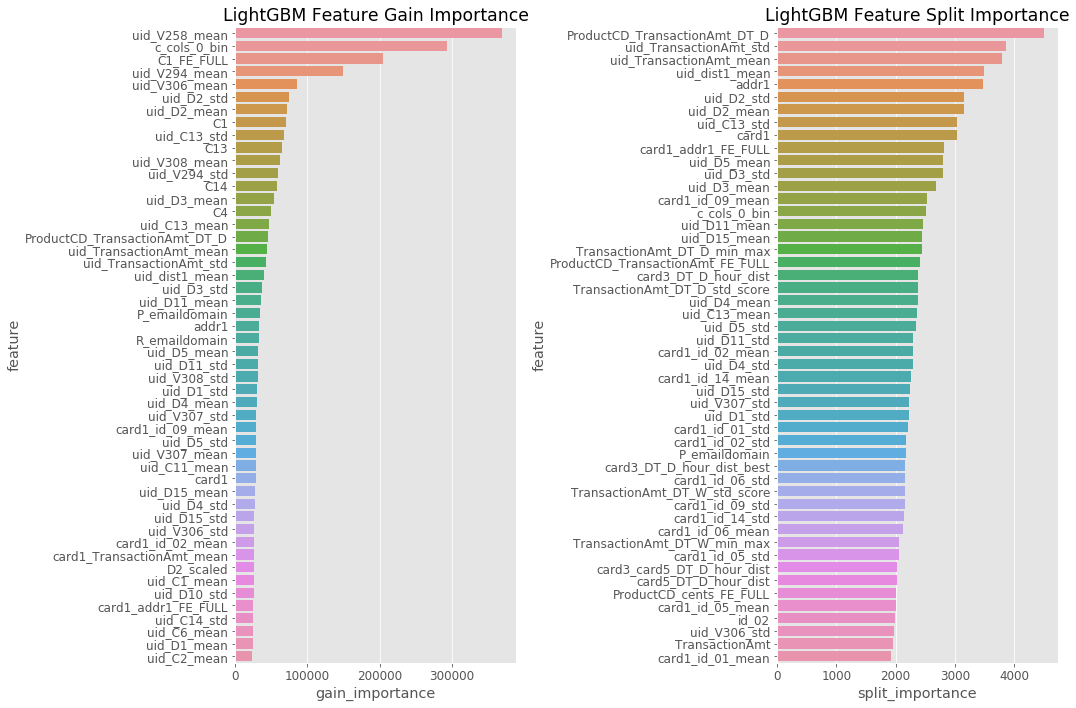

,feature,gain_importance,split_importance
0,ProductCD_TransactionAmt_DT_D,45347.560536,4512.333333
1,uid_TransactionAmt_std,42872.036796,3868.000000
2,uid_TransactionAmt_mean,44098.750484,3790.333333
3,uid_dist1_mean,39315.072375,3494.000000
4,addr1,32903.943836,3469.333333
5,uid_D2_std,74407.236046,3162.666667
6,uid_D2_mean,71277.313286,3160.666667
7,uid_C13_std,67439.327697,3043.666667
8,card1,28225.266882,3039.000000
9,card1_addr1_FE_FULL,24637.615401,2812.000000


In [22]:
X_train, X_val, category_cols1 = fe1(X_train, X_val)
fi_df, best_iteration1, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=category_cols1)

In [23]:
np.save('val_preds_lgb.npy', val_preds)

In [24]:
X, X_test, category_cols = fe1(X, X_test)
preds = make_test_prediction(X, y, X_test, best_iteration1, category_cols=category_cols)

Rare data card1 5993
No intersection in Train card1 10396
Intersection in Train card1 580144
####################
Rare data ProductCD_card1 13331
No intersection in Train ProductCD_card1 17776
Intersection in Train ProductCD_card1 572764
####################
Rare data card1_addr1 29341
No intersection in Train card1_addr1 36643
Intersection in Train card1_addr1 553897
####################
Rare data TransactionAmt_dist2 47266
No intersection in Train TransactionAmt_dist2 72303
Intersection in Train TransactionAmt_dist2 518237
####################
No intersection in Train card2 5012
Intersection in Train card2 585528
####################
No intersection in Train card3 47
Intersection in Train card3 590493
####################
No intersection in Train card4 0
Intersection in Train card4 590540
####################
No intersection in Train card5 7279
Intersection in Train card5 583261
####################
No intersection in Train card6 30
Intersection in Train card6 590510
################

uid_aggregation: card3_id_14_mean
uid_aggregation: card3_id_14_std
uid_aggregation: card5_id_14_mean
uid_aggregation: card5_id_14_std
uid_aggregation: uid_id_14_mean
uid_aggregation: uid_id_14_std
uid_aggregation: card3_card5_id_14_mean
uid_aggregation: card3_card5_id_14_std
uid_aggregation: uid_V258_mean
uid_aggregation: uid_V258_std
uid_aggregation: card3_card5_V258_mean
uid_aggregation: card3_card5_V258_std
uid_aggregation: uid_V306_mean
uid_aggregation: uid_V306_std
uid_aggregation: card3_card5_V306_mean
uid_aggregation: card3_card5_V306_std
uid_aggregation: uid_V307_mean
uid_aggregation: uid_V307_std
uid_aggregation: card3_card5_V307_mean
uid_aggregation: card3_card5_V307_std
uid_aggregation: uid_V308_mean
uid_aggregation: uid_V308_std
uid_aggregation: card3_card5_V308_mean
uid_aggregation: card3_card5_V308_std
uid_aggregation: uid_V294_mean
uid_aggregation: uid_V294_std
uid_aggregation: card3_card5_V294_mean
uid_aggregation: card3_card5_V294_std
timeblock frequency encoding: Prod

processing nan group agg for: ['V143', 'V144', 'V145', 'V150', 'V151', 'V152', 'V159', 'V160', 'V164', 'V165', 'V166']
processing nan group agg for: ['V167', 'V168', 'V172', 'V173', 'V176', 'V177', 'V178', 'V179', 'V181', 'V182', 'V183', 'V186', 'V187', 'V190', 'V191', 'V192', 'V193', 'V196', 'V199', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216']
processing nan group agg for: ['V169', 'V170', 'V171', 'V174', 'V175', 'V180', 'V184', 'V185', 'V188', 'V189', 'V194', 'V195', 'V197', 'V198', 'V200', 'V201', 'V208', 'V209', 'V210']
processing nan group agg for: ['V217', 'V218', 'V219', 'V223', 'V224', 'V225', 'V226', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V235', 'V236', 'V237', 'V240', 'V241', 'V242', 'V243', 'V244', 'V246', 'V247', 'V248', 'V249', 'V252', 'V253', 'V254', 'V257', 'V258', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278']
processing nan group

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'c_cols_0_bin', 'card4', 'card6', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Fold: 2
472431


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'c_cols_0_bin', 'card4', 'card6', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Fold: 3
472432


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'c_cols_0_bin', 'card4', 'card6', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Fold: 4
472433


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'c_cols_0_bin', 'card4', 'card6', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Fold: 5
472433


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['DeviceType', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain', 'ProductCD', 'R_emaildomain', 'c_cols_0_bin', 'card4', 'card6', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [25]:
np.save('preds_lgb.npy', preds)

In [26]:
sample_submission['isFraud'] = np.mean(preds, axis=1)
sample_submission.to_csv('submission_lgb.csv')
sample_submission.head()

,isFraud
TransactionID,
3663549,0.000809
3663550,0.000324
3663551,0.000517
3663552,0.000427
3663553,0.000197


# Validation AUC : 0.94838, Public LB : 0.959666, Private LB : 0.937376